# Predict age and gender from CFPs
In this notebook, we will use Deep Learning to predict age and gender from Color Fundus Photos. We will use the ODIR-5k datasets available from Kaggle at https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k

## Download Dataset

In [1]:
#!/bin/bash
# download the dataset
!curl -L -o ocular-disease-recognition-odir5k.zip\
  https://www.kaggle.com/api/v1/datasets/download/andrewmvd/ocular-disease-recognition-odir5k
# unzip it (exclude the preprocessed_images folder to save space)
!unzip -q ocular-disease-recognition-odir5k.zip -x "preprocessed_images"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1661M  100 1661M    0     0   148M      0  0:00:11  0:00:11 --:--:--  155M
caution: excluded filename not matched:  preprocessed_images


## Setup and configuration

Initial imports and variables

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

BASE_DATA_DIR = '../ODIR-5K/ODIR-5K/Training Images' # base directory for images
METADATA_FILE = '../full_df.csv' # csv file with age and gender info

AGE_COLUMN = 'Patient Age'
GENDER_COLUMN = 'Patient Sex'
LATERALITY_COLUMN = 'Laterality'

# sanity checks
assert os.path.exists(BASE_DATA_DIR), f'Training images directory [{BASE_DATA_DIR}] does not exist'

In [2]:
TARGET_COLUMN = GENDER_COLUMN
BATCH_SIZE = 64
NUM_EPOCHS = 10 # 3 (for age) 10 (for gender), 1 (for laterality)
LEARNING_RATE = 0.01 #0.01 (for gender, laterality) 0.001 (for age)
IMG_SIZE = (224, 224) 

## Data preprocessing

The dataset is divided into Training and Testing, but we do not have ground truth labels for the Testing images, so we will ignore them

The data is organized as follows:
- ODIR-5K/ODIR-5K
  - Testing Images: to ignore - no ground truth
  - Training Images: images to be used for training/validation/test (in jpeg format)
- full_df.csv: csv file with meta data for the ODIR-5K dataset (e.g., age and gender)

In [3]:
from sklearn.model_selection import train_test_split

# split percentages
TEST_SIZE = 0.2 # test is 20%
VAL_SIZE = 0.2 / (1 - TEST_SIZE) # val is 20% of overall dataset, so it's (20/80)% of the train+val split

In [4]:
print("Loading metadata and preprocessing data...")
df = pd.read_csv(METADATA_FILE)

# create a column with both file paths (left and right) - will be useful later
df['filenames'] = df.apply(lambda x: x[['Left-Fundus', 'Right-Fundus']].values.tolist(), axis=1)

# Handle the target column
# Convert age to numeric
df[AGE_COLUMN] = pd.to_numeric(df[AGE_COLUMN], errors='coerce')

# Map gender to 0/1
df[GENDER_COLUMN] = df[GENDER_COLUMN].map({'Male': 0, 'Female': 1})
df[GENDER_COLUMN] = df[GENDER_COLUMN].astype(int)

# check that there are no missing values
print('Any missing values in target columns:')
print(df[[AGE_COLUMN, GENDER_COLUMN]].isna().any())

print(f"Gender and age distributions:")
print(df[[AGE_COLUMN, GENDER_COLUMN]].describe())

# generate train/test/val (60:20:20) splits at patient level (the dataframe has one row per patient). Set random_state for reproducibility
trainval, test = train_test_split(df, test_size=TEST_SIZE, random_state=42)
train, val = train_test_split(trainval, test_size=VAL_SIZE, random_state=42)

# check that the splits were done correctly and that we obtained the intended patient-level ratios
df['split'] = 'train'
df.loc[test.index, 'split'] = 'test'
df.loc[val.index, 'split'] = 'val'

# sanity check: all patients selected for training are actually in the training split
assert (df['split'].iloc[train.index].eq('train')).all(), 'Train split is not correct'

print('Number and percentage of patients in each split')
print(df.groupby('split').agg({'filename': ['count', ('percentage', lambda x: x.count()/len(df))]}))

# go from dataframes at patient level to dataframes at image level
train = train.explode('filenames')
val = val.explode('filenames')
test = test.explode('filenames')

# normalize age for more stable training
mean_val = val[AGE_COLUMN].mean()
std_val = val[AGE_COLUMN].std()
val[AGE_COLUMN] = (val[AGE_COLUMN] - mean_val) / std_val
train[AGE_COLUMN] = (train[AGE_COLUMN] - mean_val) / std_val
test[AGE_COLUMN] = (test[AGE_COLUMN] - mean_val) / std_val

# add laterality column based on the filename Right = 1
train[LATERALITY_COLUMN] = train['filenames'].apply(lambda x: int('right' in x))
val[LATERALITY_COLUMN] = val['filenames'].apply(lambda x: int('right' in x))
test[LATERALITY_COLUMN] = test['filenames'].apply(lambda x: int('right' in x))

# after this opearation, filenames will store the name of the image the dataframe row refers to

print('Number of images in each split')
print(f'Train: {len(train):,d}')
print(f'Val: {len(val):,d}')
print(f'Test: {len(test):,d}')

Loading metadata and preprocessing data...
Any missing values in target columns:
Patient Age    False
Patient Sex    False
dtype: bool
Gender and age distributions:
       Patient Age  Patient Sex
count  6392.000000  6392.000000
mean     57.857947     0.464330
std      11.727737     0.498765
min       1.000000     0.000000
25%      51.000000     0.000000
50%      59.000000     0.000000
75%      66.000000     1.000000
max      91.000000     1.000000
Number and percentage of patients in each split
      filename           
         count percentage
split                    
test      1279   0.200094
train     3834   0.599812
val       1279   0.200094
Number of images in each split
Train: 7,668
Val: 2,558
Test: 2,558


## Dataset implementation
We now need to define a Dataset class to load the images during training/evaluation

In [5]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [6]:
class ODIRDataset(Dataset):
    def __init__(self, dataframe, img_base_dir, target_column, transform=None):
        self.dataframe = dataframe
        self.img_base_dir = img_base_dir
        self.target_column = target_column
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Returns the image, label pair associated with index idx"""

        row = self.dataframe.iloc[idx]
        # get the image name
        img_filename = row['filenames']
        # get the gound truth label
        target = row[self.target_column]

        # assemble the image path
        img_path = os.path.join(self.img_base_dir, img_filename)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Convert target to tensor
        if self.target_column == AGE_COLUMN:
            target = torch.tensor(float(target), dtype=torch.float32)
        elif self.target_column in [GENDER_COLUMN, LATERALITY_COLUMN]:
            target = torch.tensor(int(target), dtype=torch.float32) # Use float for BCEWithLogitsLoss

        return image, target

In [7]:
# Define transformations
if TARGET_COLUMN == LATERALITY_COLUMN:
    # do not flip the image since that would change the laterality
    train_transforms = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
else:
    train_transforms = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = ODIRDataset(train, BASE_DATA_DIR, TARGET_COLUMN, train_transforms)
val_dataset = ODIRDataset(val, BASE_DATA_DIR, TARGET_COLUMN, val_test_transforms)
test_dataset = ODIRDataset(test, BASE_DATA_DIR, TARGET_COLUMN, val_test_transforms)

print('Dataset sizes:')
print(f'Train: {len(train_dataset):,d}')
print(f'Val: {len(val_dataset):,d}')
print(f'Test: {len(test_dataset):,d}')

Dataset sizes:
Train: 7,668
Val: 2,558
Test: 2,558


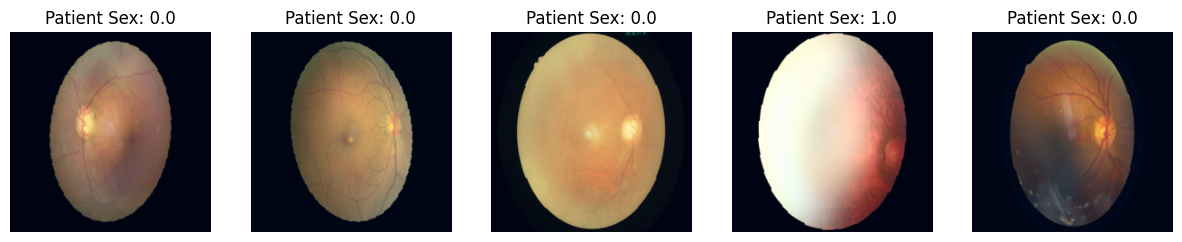

In [8]:
# visualize a few examples
import matplotlib.pyplot as plt
N = 5

idx_to_sample = np.random.choice(len(train_dataset), N)

fig, axs = plt.subplots(1, N, figsize=(15, 5))
for i, idx in enumerate(idx_to_sample):
    img, label = train_dataset[idx]
    # normalize to [0,1] -> due to transforms, image data is not within this range and matplotlib would clip anything outside [0,1]
    img = (img - img.min()) / (img.max() - img.min())
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'{TARGET_COLUMN}: {label}')
    axs[i].axis('off')

plt.show()

In [9]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train DataLoader size: {len(train_loader)} batches")
print(f"Validation DataLoader size: {len(val_loader)} batches")
print(f"Test DataLoader size: {len(test_loader)} batches")

Train DataLoader size: 120 batches
Validation DataLoader size: 40 batches
Test DataLoader size: 40 batches


## Model initialization
We pick a simple ResNet18, but we can change this code and pick any other network architecture

In [10]:
print("Initializing ResNet18 model...")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Use recommended weights

# Modify the final fully connected layer based on the target task
# for both binary classification and regression, we need 1 output number (i.e., logits for binary classification and age for regression)
model.fc = torch.nn.Linear(model.fc.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

Initializing ResNet18 model...
Using device: cuda


## Train the model

In [11]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [12]:
# define the loss, depending on type of task (i.e., binary classification or regression)
if TARGET_COLUMN == AGE_COLUMN:
    criterion = torch.nn.MSELoss()
    metric_name = 'MSE'
elif TARGET_COLUMN in [GENDER_COLUMN, LATERALITY_COLUMN]:
    criterion = torch.nn.BCEWithLogitsLoss()
    metric_name = 'Accuracy'

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_metric': []}
model_dir = f'../results/{TARGET_COLUMN}/resnet'
os.makedirs(model_dir, exist_ok=True)

best_model_path = f'{model_dir}/best_model.pth'

In [13]:
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch}: training'):
        # place inputs and outputs on the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)

        # zero-out gradients at each epoch
        optimizer.zero_grad()
        # forward pass
        outputs = model(inputs)
        assert not any(torch.isnan(outputs))

        # compute the loss
        loss = criterion(outputs.squeeze(), targets) # Squeeze output to match target shape

        # backward pass: compute gradients
        loss.backward()
        # update weights
        optimizer.step()
        # keep track of the training loss
        running_loss += loss.item() * inputs.size(0)

    # compute overall epoch loss
    epoch_train_loss = running_loss / len(train) # Use len(train) for total samples, not len(train_loader) * BATCH_SIZE

    # Validation phase
    # set model in eval mode - (e.g., no dropout)
    model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_targets = []
    # do not compute gradients - we do not need them, saves memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Epoch {epoch}: validation'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if TARGET_COLUMN == AGE_COLUMN:
                val_loss = criterion(outputs.squeeze(), targets)
                preds = outputs.squeeze().cpu().numpy()
            elif TARGET_COLUMN in [GENDER_COLUMN, LATERALITY_COLUMN]:
                val_loss = criterion(outputs.squeeze(), targets)
                # apply a sigmoid - BCEWithLogits computes the loss from the logits
                # at inference, we need probabilities to compare them with a threshold (default 0.5) to classify a sample
                preds = torch.sigmoid(outputs.squeeze()).cpu().numpy() > 0.5 # Convert logits to binary predictions

            val_running_loss += val_loss.item() * inputs.size(0)
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy())

    epoch_val_loss = val_running_loss / len(val) # Use len(val) for total samples

    current_metric = 0.0
    if TARGET_COLUMN == AGE_COLUMN:
        current_metric = mean_squared_error(all_targets, all_preds)
    elif TARGET_COLUMN in [GENDER_COLUMN, LATERALITY_COLUMN]:
        current_metric = accuracy_score(all_targets, all_preds)

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_metric'].append(current_metric)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val {metric_name}: {current_metric:.4f}")

    # Save checkpoint based on best validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"--- Saved best model with Val Loss: {best_val_loss:.4f} ---")

print("Training complete.")

Starting training...


Epoch 0: validation: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]

Epoch 1/10 - Train Loss: 0.6839, Val Loss: 0.7131, Val Accuracy: 0.5500
--- Saved best model with Val Loss: 0.7131 ---



Epoch 1: validation: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]

Epoch 2/10 - Train Loss: 0.6528, Val Loss: 0.6858, Val Accuracy: 0.5829
--- Saved best model with Val Loss: 0.6858 ---



Epoch 2: validation: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]

Epoch 3/10 - Train Loss: 0.6308, Val Loss: 0.6799, Val Accuracy: 0.5876
--- Saved best model with Val Loss: 0.6799 ---



Epoch 3: validation: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]

Epoch 4/10 - Train Loss: 0.6023, Val Loss: 0.6638, Val Accuracy: 0.6075
--- Saved best model with Val Loss: 0.6638 ---



Epoch 4: validation: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


Epoch 5/10 - Train Loss: 0.5758, Val Loss: 0.6614, Val Accuracy: 0.6149
--- Saved best model with Val Loss: 0.6614 ---


Epoch 5: validation: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]

Epoch 6/10 - Train Loss: 0.5471, Val Loss: 0.6395, Val Accuracy: 0.6400
--- Saved best model with Val Loss: 0.6395 ---



Epoch 6: validation: 100%|██████████| 40/40 [00:43<00:00,  1.09s/it]

Epoch 7/10 - Train Loss: 0.5124, Val Loss: 0.6380, Val Accuracy: 0.6415
--- Saved best model with Val Loss: 0.6380 ---



Epoch 7: validation: 100%|██████████| 40/40 [00:44<00:00,  1.10s/it]

Epoch 8/10 - Train Loss: 0.4745, Val Loss: 0.6453, Val Accuracy: 0.6501



Epoch 8: validation: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]

Epoch 9/10 - Train Loss: 0.4425, Val Loss: 0.6324, Val Accuracy: 0.6900
--- Saved best model with Val Loss: 0.6324 ---



Epoch 9: validation: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]

Epoch 10/10 - Train Loss: 0.4040, Val Loss: 0.6270, Val Accuracy: 0.6939
--- Saved best model with Val Loss: 0.6270 ---
Training complete.


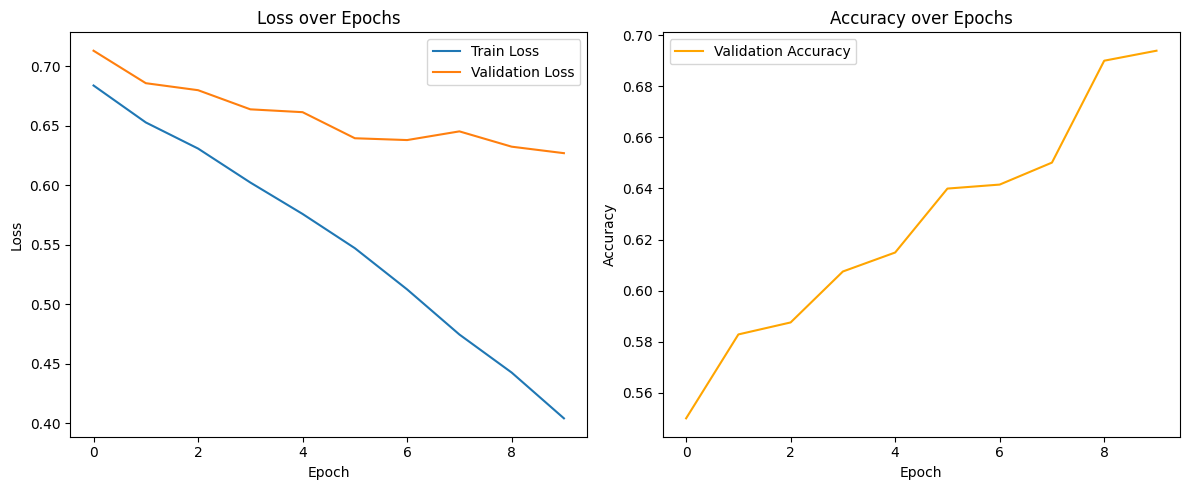

In [14]:
# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_metric'], label=f'Validation {metric_name}', color='orange')
plt.title(f'{metric_name} over Epochs')
plt.xlabel('Epoch')
plt.ylabel(metric_name)
plt.legend()
plt.tight_layout()
plt.show()

## Test the network

In [15]:
import math
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, roc_auc_score, mean_squared_error, roc_curve, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
print("\nTesting the network on the testing images...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_running_loss = 0.0
all_test_preds = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Testing'):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        test_loss = criterion(outputs.squeeze(), targets)

        if TARGET_COLUMN == AGE_COLUMN:
            preds = outputs.squeeze().cpu().numpy()
        elif TARGET_COLUMN in [GENDER_COLUMN, LATERALITY_COLUMN]:
            preds = torch.sigmoid(outputs.squeeze()).cpu().numpy() > 0.5

        test_running_loss += test_loss.item() * inputs.size(0)
        all_test_preds.extend(preds)
        all_test_targets.extend(targets.cpu().numpy())

final_test_loss = test_running_loss / len(test)


Testing the network on the testing images...


/tmp/ipykernel_1585960/2423763006.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
Testing:   0%|          | 0/40 [00:0

Testing: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


In [31]:
if TARGET_COLUMN == AGE_COLUMN:
    all_test_preds = np.array(all_test_preds) * std_val + mean_val
    all_test_targets = np.array(all_test_targets) * std_val + mean_val

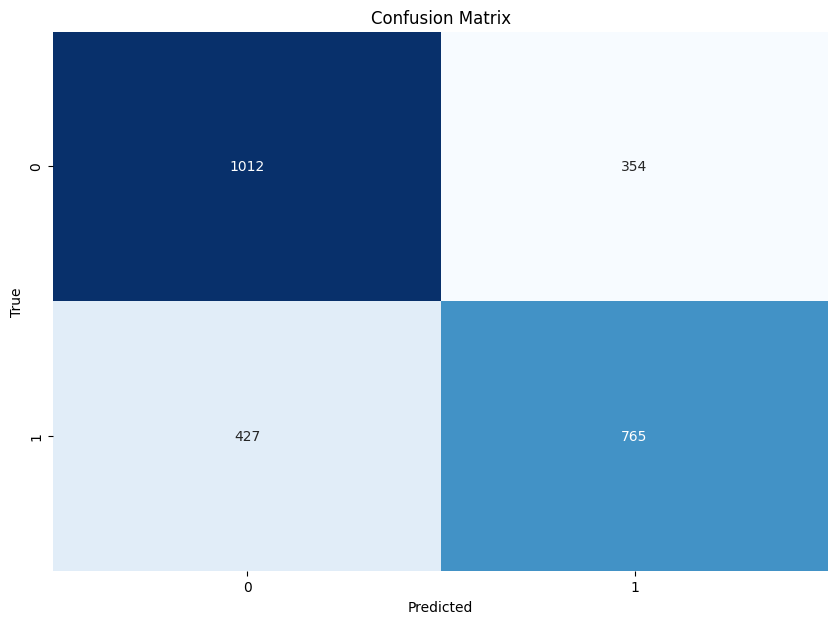

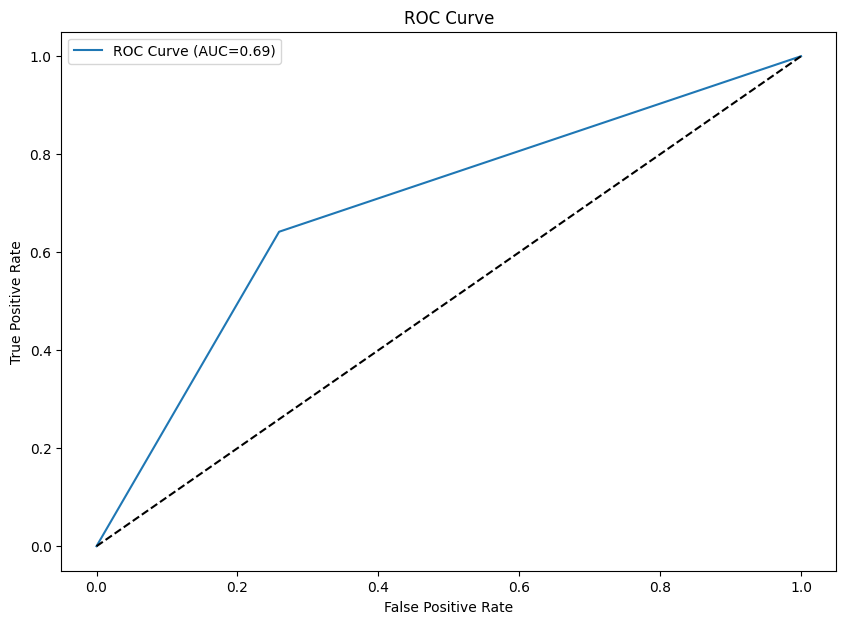

Final Test AUC-ROC Score: 0.6913
Final Test Loss (BCE): 0.6299
Final Test Accuracy: 0.6947


In [17]:
# plot results
if TARGET_COLUMN == AGE_COLUMN:
    final_metric_value = mean_squared_error(all_test_targets, all_test_preds)
    # Calculate RMSE for age
    print(f"Final Test RMSE: {math.sqrt(final_metric_value):.4f}")
    print(f'Final test MAE: {mean_absolute_error(all_test_targets, all_test_preds):.4f}')
    print(f'Final test R2: {r2_score(all_test_targets, all_test_preds):.4f}')
    # scatter plot of age vs predicted age
    plt.scatter(all_test_targets, all_test_preds)
    plt.plot(all_test_targets, all_test_targets, color='red')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('Age vs Predicted Age')
    plt.show()
    # R2 score
    print(f"Final Test R2 Score: {r2_score(all_test_targets, all_test_preds):.4f}")
elif TARGET_COLUMN in [GENDER_COLUMN, LATERALITY_COLUMN]:
    final_metric_value = accuracy_score(all_test_targets, all_test_preds)
    # confusion matrix
    cm = confusion_matrix(all_test_targets, all_test_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # ROC curve
    auc = roc_auc_score(all_test_targets, all_test_preds)
    fpr, tpr, thresholds = roc_curve(all_test_targets, all_test_preds)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc:.2f})')
    # add random line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    # compute AUC-ROC score
    print(f"Final Test AUC-ROC Score: {auc:.4f}")
    print(f"Final Test Loss (BCE): {final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_metric_value:.4f}")